In [1]:
import numpy as np
import cv2 as cv
from skimage import filters, morphology, measure, segmentation, color
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = (20, 10)

In [2]:
def get_diameter_ROI(frame):
    print("Select ROI for Diameter Calculations")
    r = cv.selectROI(frame)

    return r

In [3]:
filename = "ASCI008 baseline long diam 20201008124425657"
capture = cv.VideoCapture(f"raw_video/{filename}.avi")

_, frame = capture.read()
r= get_diameter_ROI(frame)
cv.destroyAllWindows()

img = frame[int(r[1]):int(r[1]+r[3]), int(r[0]):int(r[0]+r[2])]
img = cv.rotate(img, cv.ROTATE_90_COUNTERCLOCKWISE)

Select ROI for Diameter Calculations


# Preprocessing
Using contrast to make the vessel, which will most likely be darker than the rest of the image, stand out more against the background.

Blurring the image so that the edges on the edge wall become smoother. This also helps random dark and light spots in the ultrasound image become blended in with their surroundings to prevent hiccups in the Otsu thresholding later.

In [4]:

def preprocess_opencv(image):
    src = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    contrasted = cv.equalizeHist(src)
    blur = cv.bilateralFilter(contrasted, 9, 75, 75)
    return blur

# Edge Detection

Using Sobel edge detection instead of the Canny Edge detection. This is because Sobel edge detection runs faster and retains more visual information. This will also be used in the Watershed algorithm later for image segmentation.

The Watershed image segmentation should pay attention to the differences in brightness more accurately than relying solely on Canny edge detection. 

Multi-Otsu thresholding provides an accurate binarization of the image that lends well to the Watershed results; however, visual information is often lost. For some images, this can create a crystal clear image of the blood vessel, but other times the thresholding can be too harsh and blend the image of the blood vessel into its surroundings. For this reason, if the Otsu thresholding creates less than 3 separate objects, it will use normal Otsu thresholding, rather than multi-Otsu thresholding.

After thresholding, the boundaries of these are used as the edges for the diameter calculations.

In [5]:

def preprocess_skimage(image):

    edges = filters.sobel(image)
    
    fig, ax = plt.subplots(1, 4)
    
    thresh = filters.threshold_multiotsu(image)

    markers = np.zeros_like(image)
    markers[image > thresh[1]] = 1
    markers[image < thresh[0]] = 2

    ws = segmentation.watershed(edges, markers)

    ws = morphology.closing(ws)
    ws = morphology.opening(ws)

    labels = measure.label(ws == 2)
    ax[1].imshow(color.label2rgb(labels))
    
    if len(np.unique(labels)) < 4:

        thresh = filters.threshold_otsu(image)
        markers[image > thresh] = 1
        markers[image < thresh] = 2
        ws = segmentation.watershed(edges, markers)

    ws = morphology.closing(ws)
    ws = morphology.opening(ws)
    
    boundaries = segmentation.find_boundaries(ws, mode='inner')
    
    
    labels = measure.label(ws == 2)

    ax[0].imshow(edges)
    ax[2].imshow(color.label2rgb(labels))
    ax[3].imshow(boundaries)
    
    for a in ax:
        a.axis('off')
    plt.tight_layout()
    plt.show()
    return boundaries



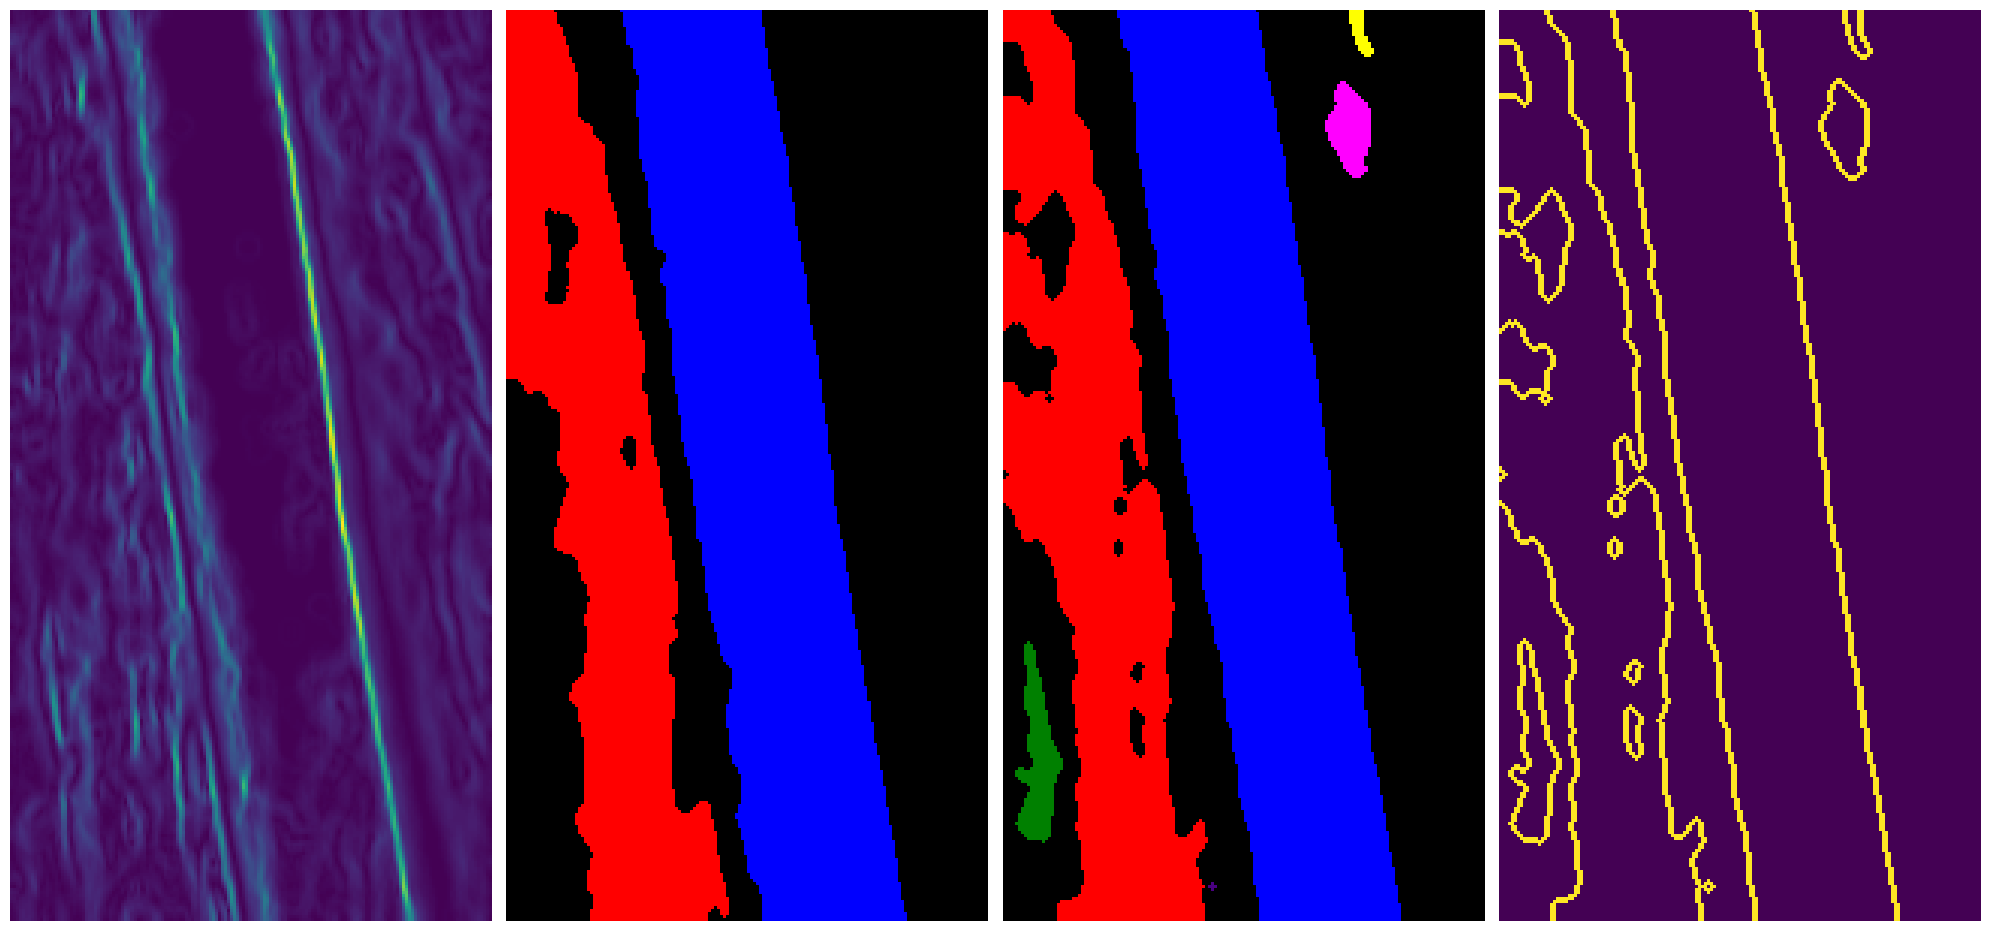

In [6]:
cv_img = preprocess_opencv(img)
clean_img = preprocess_skimage(cv_img)

# Edge Artifact Removal and Diameter Calculation

Edges are grouped into groups of pixels that make *any* contact with any other pixel. These are then removed if they do not occupy at least 75% of the vertical space of the image. 

After these are removed, the 2 labels that are the "straightest" are kept. Straightness is measured by sum of residuals after a line of best fit is fit onto that label.

Once the two labels that are determined to be the blood vessel walls are picked, two parallel lines are fit to the blood vessel wall. This is calculated by minimizing sum of least squares so that they share the same $\theta_2$, but different intercepts.

$$ h(\theta_0, \theta_1, \theta_2) = \sum_{i=1}^{N} (y_{0_i} - (\theta_0 + \theta_2 x_{0_i}))^2 + (y_{1_i} - (\theta_1 + \theta_2 x_{1_i}))^2$$

This reduces to:
$$\theta_2 = \frac{\overline{x_0 y_0} + \overline{x_1 y_1} - \overline{x_0} \overline{y_0} - \overline{x_1} \overline{y_1} } {\overline{{x_0}^2} + \overline{{x_1}^2} - \overline{{x_0}}^2 - \overline{{x_1}}^2 } $$

$$\theta_0 = \overline{y_0} - \theta_2 \overline{x_0} $$
$$\theta_1 = \overline{y_1} - \theta_2 \overline{x_1} $$

From here, the distance between two parallel lines is 
$$ diameter = \frac{|\theta_0 - \theta_1|} {\sqrt{1+{\theta_2}^2} }$$


In [7]:
def get_pixel_diameter(image, ax=None):
    # Labels image into connected pixels using 2-Connectivity (grouped into any series of pixels touching edges or corners)
    labeled_image = measure.label(image, connectivity=2)
    # Get the height of the image
    height = image.shape[0]

    # Compute properties
    regions = measure.regionprops(labeled_image)
    filtered_labels = []
    filtered_image = labeled_image.copy()

    for i in range(len(regions)):
        if regions[i].axis_major_length > height//1.3:
            filtered_labels.append(regions[i].label)
        else:
            filtered_image[filtered_image == regions[i].label] = 0

    if len(filtered_labels) < 2:
        return np.NaN

    elif len(filtered_labels) > 2:
        filtered_labels = np.array(filtered_labels)
        residuals = np.empty_like(filtered_labels)
        for i in range(len(filtered_labels)):
            label_mask = labeled_image == filtered_labels[i]
            y, x = np.where(label_mask)
            residuals[i] = np.polyfit(x, y, 1, full=True)[1].item()
        filtered_labels = filtered_labels[np.argsort(residuals)[:2]]

    y_mean = np.empty(2)
    x_mean = np.empty(2)
    xy_mean = np.empty(2)
    x_squared_mean = np.empty(2)
    for i in range(2):
        label_mask = labeled_image == filtered_labels[i]
        y, x = np.where(label_mask)
        y_mean[i] = y.mean()
        x_mean[i] = x.mean()
        xy_mean[i] = (x*y).mean()
        x_squared_mean[i] = (x**2).mean()

    slope = (xy_mean[0] + xy_mean[1] - x_mean[0]*y_mean[0] - x_mean[1]*y_mean[1]
             ) / (x_squared_mean[0]+x_squared_mean[1] - x_mean[0]**2 - x_mean[1]**2)
    intercept = y_mean - slope * x_mean

    if not ax == None:
        for inter in intercept:
            ax.axline((0, inter), slope=slope, color="red")

        ax.imshow(filtered_image)

    diameter = np.abs(intercept[0] - intercept[1]) / \
                np.sqrt(1+slope**2)
    return diameter

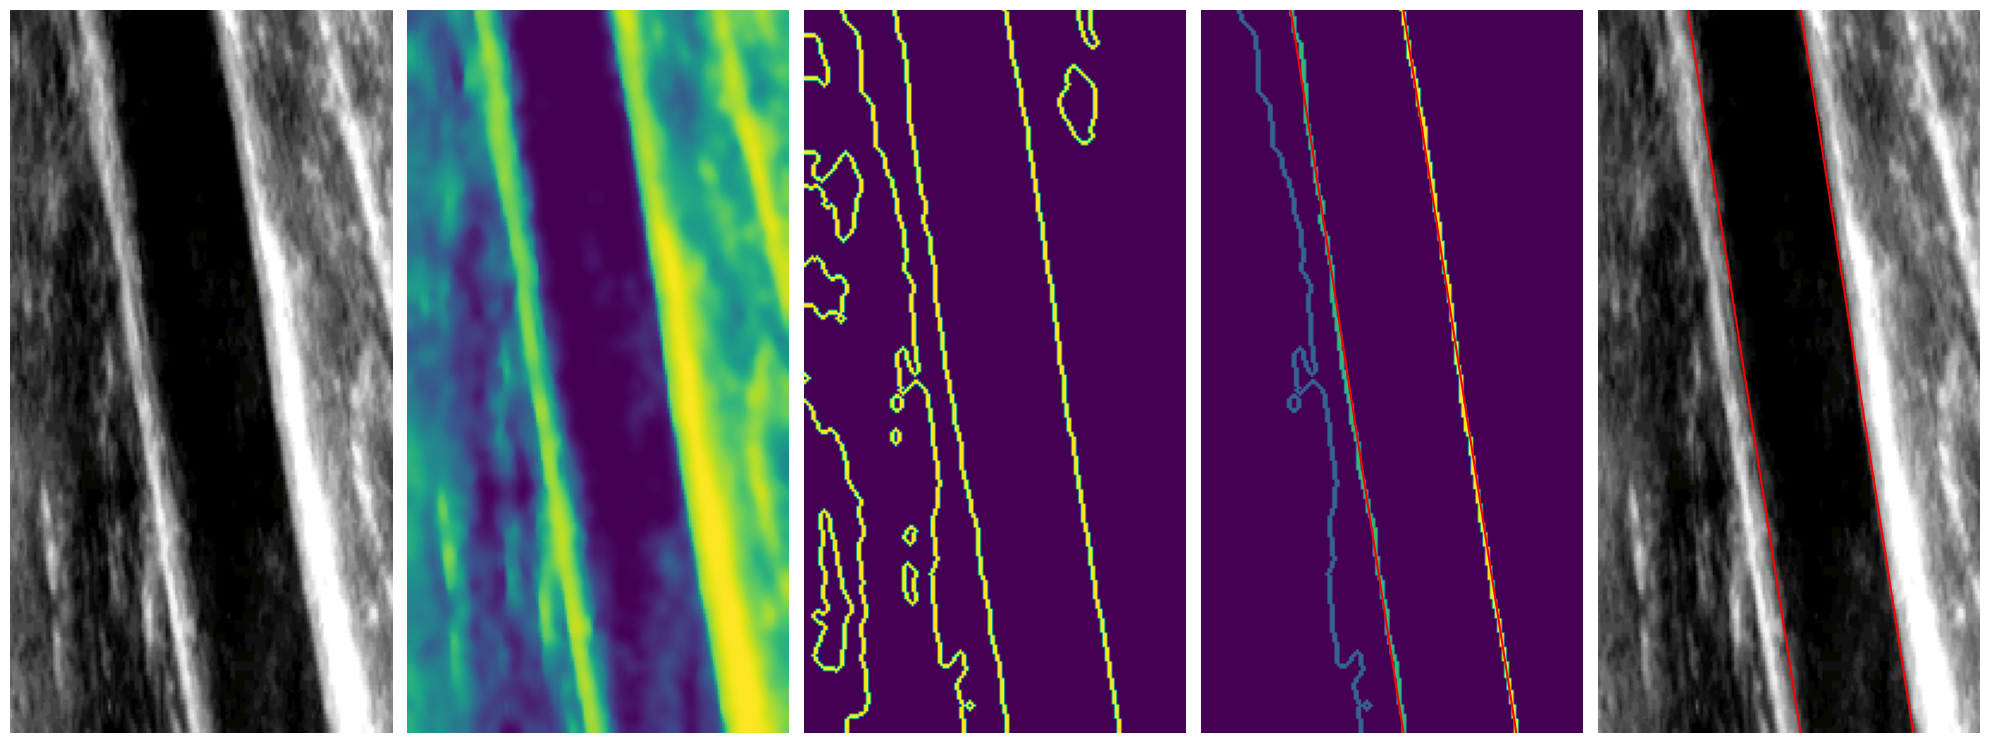

In [8]:
fig, ax = plt.subplots(1,5)
ax[0].imshow(img)
ax[1].imshow(cv_img)
ax[2].imshow(clean_img)
get_pixel_diameter(clean_img, ax = ax[3])
get_pixel_diameter(clean_img, ax = ax[4])
ax[4].imshow(img)

for a in ax:
    a.axis('off')

plt.tight_layout()
plt.show()